In [1]:
import pandas as pd
import helper
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [2]:
idx_cols = ['subj_id', 'tta_condition', 'd_condition']

exp_data = pd.read_csv('../data/measures.csv')
model_params_path = '../model_fit_results/cross_validation_or_merged.csv'
model_measures_path = '../model_fit_results/cross_validation_or_measures.csv'
model_params = pd.read_csv(model_params_path).rename(columns={'tta': 'tta_condition', 'd': 'd_condition'})
model_params = model_params.set_index(['subj_id', 'tta_condition', 'd_condition'])
model_measures = pd.read_csv(model_measures_path)
model_measures = model_measures.join(model_params['loss'], on=idx_cols)
get_turn_count = lambda g: len(g[g.is_turn_decision])
counts = pd.DataFrame(exp_data.groupby(idx_cols).apply(get_turn_count).rename('test_set_size'))
counts = counts.join(exp_data.groupby('subj_id').apply(get_turn_count).rename('overall_size'))
counts['train_set_size'] = counts.overall_size - counts.test_set_size
model_measures = model_measures.join(counts['train_set_size'], on=idx_cols)

p_turn_exp = exp_data.groupby(['subj_id', 'tta_condition', 'd_condition']).is_turn_decision.mean().rename('p_turn_exp')
model_measures = model_measures.join(p_turn_exp, on=idx_cols)
model_measures['p_diff'] = 4*(model_measures.p_turn_exp - model_measures.is_turn_decision)**2

In [3]:
model_measures.nlargest(5, 'p_diff')

,tta_condition,d_condition,is_turn_decision,RT,subj_id,loss,train_set_size,p_turn_exp,p_diff
62,6.0,120.0,0.936842,0.573981,755,0.303596,54,0.500000,0.763325
54,4.0,90.0,0.346471,0.467259,755,0.388123,58,0.000000,0.480169
17,6.0,120.0,0.821456,0.806821,389,0.186953,39,0.538462,0.320343
52,6.0,150.0,0.970979,0.730574,642,0.251704,32,0.692308,0.310630
59,5.0,120.0,0.429852,0.592908,755,0.295646,51,0.700000,0.291920


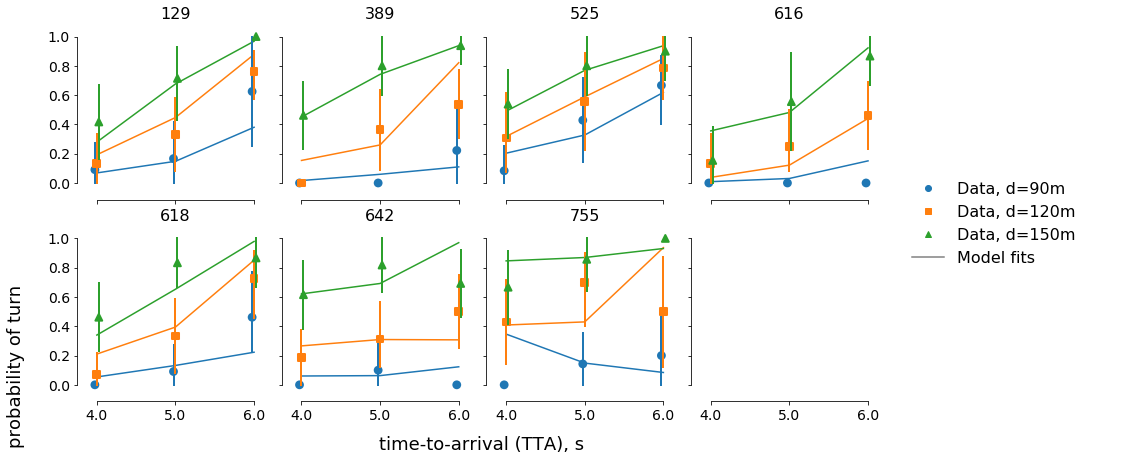

In [17]:
helper.plot_var_by_subject_v2(data=exp_data, model_measures_path=model_measures_path, 
                              var='is_turn_decision', ylabel='probability of turn');

It seems like the discrepancies on the probability plot are not reflected in loss function values. Is there a correlation between them at all?

In [68]:
np.corrcoef(model_measures.loss, model_measures.p_diff)

array([[ 1.        , -0.06969184],
       [-0.06969184,  1.        ]])

In [69]:
np.corrcoef(model_measures[model_measures.p_diff<0.4].loss, model_measures[model_measures.p_diff<0.4].p_diff)

array([[ 1.        , -0.15710782],
       [-0.15710782,  1.        ]])

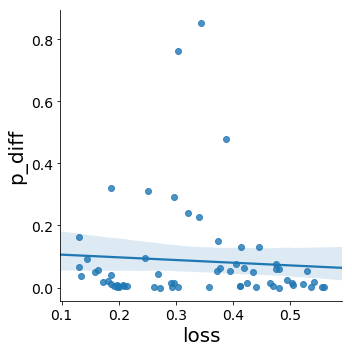

In [66]:
sns.lmplot(data=model_measures, x='loss', y='p_diff')

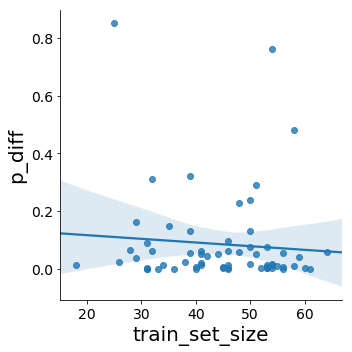

In [104]:
sns.lmplot(data=model_measures, x='train_set_size', y='p_diff')

For three conditions, p_diff is really different from loss. Let's run fitting for these three conditions multiple times and see if the found best-fit params are robust

# Model parameter analysis

In [22]:
parameters = (pd.read_csv('../model_fit_results/cross_validation_or_merged.csv')
              .rename(columns={'tta': 'tta_condition', 'd': 'd_condition'}))
parameters.subj_id = parameters.subj_id.apply(str)

$\mathop{dx} = \alpha\Big(\big(\tau+\beta d\big)-\theta\Big) \mathop{dt} + \mathop{dW}$

In [43]:
model_measures.nlargest(10, 'p_diff')

,tta_condition,d_condition,is_turn_decision,RT,subj_id,loss,train_set_size,p_turn_exp,p_diff
62,6.0,120.0,0.936842,0.573981,755,0.303596,54,0.500000,0.763325
54,4.0,90.0,0.346471,0.467259,755,0.388123,58,0.000000,0.480169
17,6.0,120.0,0.821456,0.806821,389,0.186953,39,0.538462,0.320343
52,6.0,150.0,0.970979,0.730574,642,0.251704,32,0.692308,0.310630
59,5.0,120.0,0.429852,0.592908,755,0.295646,51,0.700000,0.291920
6,6.0,90.0,0.380541,0.903722,129,0.320977,50,0.625000,0.239041
42,6.0,90.0,0.222694,0.753844,618,0.340760,48,0.461538,0.228186
28,4.0,150.0,0.356004,0.597294,616,0.131098,29,0.153846,0.163471
53,6.0,120.0,0.307183,0.693009,642,0.373173,35,0.500000,0.148713
40,5.0,150.0,0.653085,0.625637,618,0.413495,39,0.833333,0.129958


In [51]:
parameters[parameters.beta>0.2]

,subj_id,tta_condition,d_condition,loss,alpha,beta,theta,noise,b_0,k,tta_crit,ndt_location,ndt_scale
53,642,6.0,120.0,0.373173,0.225105,0.272950,39.911148,1,1.165159,0.153297,4.955254,0.391421,0.201230
54,755,4.0,90.0,0.388123,0.276572,0.292443,38.303654,1,0.580669,1.688395,4.694771,0.442810,0.114898
55,755,4.0,150.0,0.445169,0.344173,0.224091,30.468863,1,0.994351,0.207877,5.626174,0.397479,0.061106


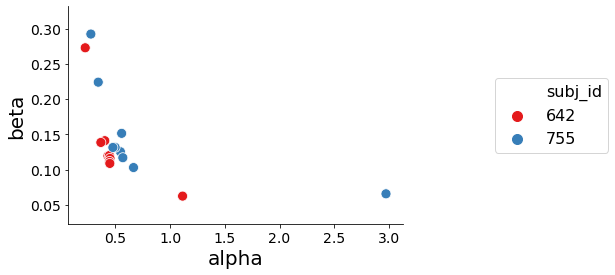

In [65]:
# data = parameters
# data = parameters[~(parameters.subj_id=='642') & ~(parameters.subj_id=='755')]
data = parameters[(parameters.subj_id=='642') | (parameters.subj_id=='755')]
# data = parameters[(parameters.subj_id=='129') | (parameters.subj_id=='525') | (parameters.subj_id=='618')]
fig, ax = plt.subplots()
x = np.linspace(0.2, 3, 20)
y = 0.07/x
# ax.plot(x, y)
sns.scatterplot(ax=ax, data=data,
                x='alpha', y='beta', hue='subj_id', 
                palette=sns.color_palette('Set1', data.subj_id.nunique()))
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

No handles with labels found to put in legend.


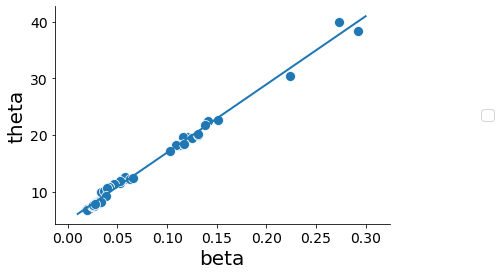

In [83]:
data = parameters
# data = parameters[~(parameters.subj_id=='642') & ~(parameters.subj_id=='755')]
# data = parameters[(parameters.subj_id=='129') | (parameters.subj_id=='525') | (parameters.subj_id=='618')]
reg_coeffs = scipy.stats.linregress(x=data.beta, y=data.theta)

fig, ax = plt.subplots()
x = np.linspace(0.01, 0.3, 20)
y = reg_coeffs.intercept+x*reg_coeffs.slope
sns.scatterplot(ax=ax, data=data,
                x='beta', y='theta'#, hue='subj_id', palette=sns.color_palette('Set1', data.subj_id.nunique())
           )

ax.plot(x, y)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [81]:
reg_coeffs

LinregressResult(slope=120.38275739346533, intercept=4.8576638895432405, rvalue=0.9954761328905364, pvalue=4.506830106210693e-64, stderr=1.4711152769007363)

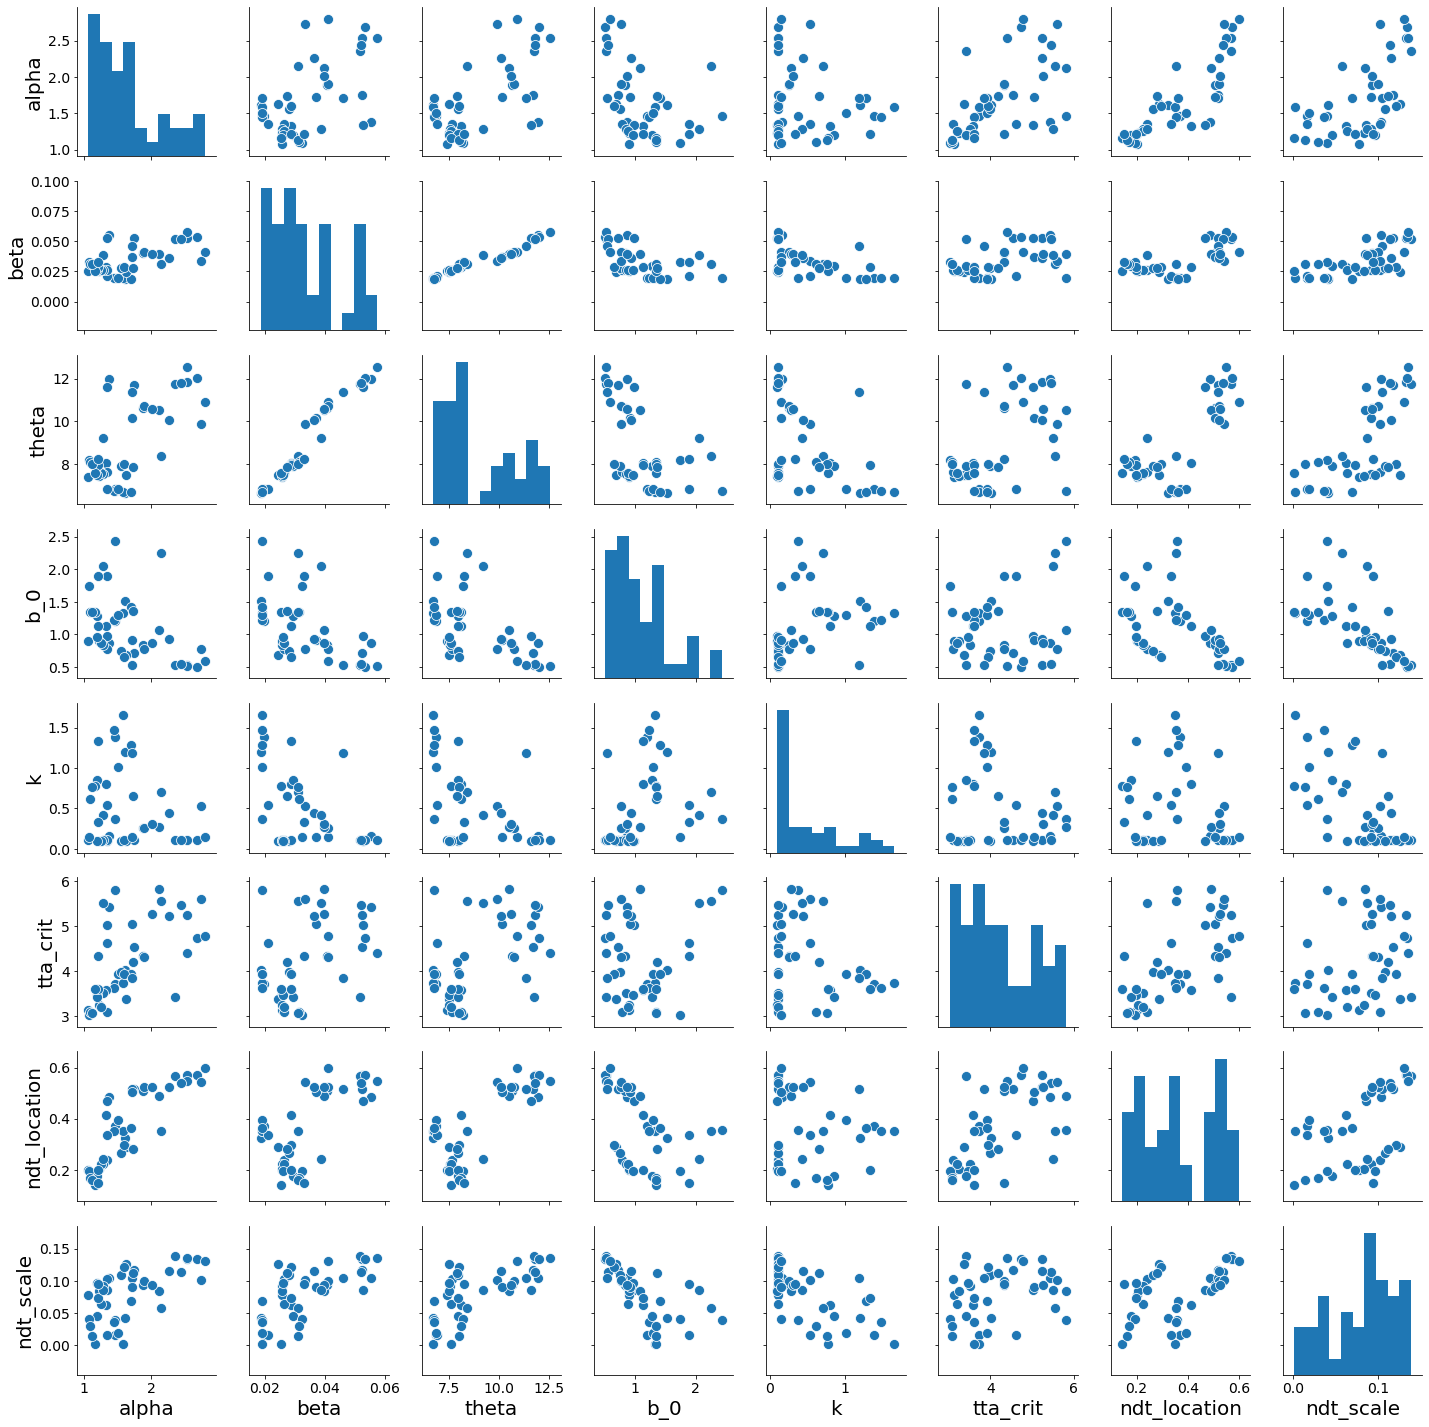

In [60]:
sns.pairplot(parameters[~(parameters.subj_id=='642') & ~(parameters.subj_id=='755')], 
             vars=['alpha', 'beta', 'theta', 'b_0', 'k', 'tta_crit', 'ndt_location', 'ndt_scale'])

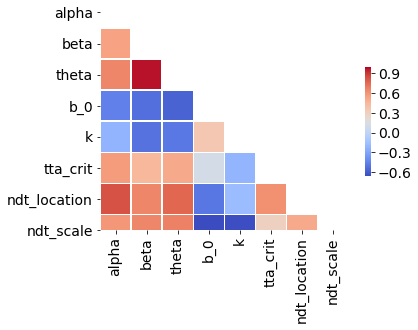

In [63]:
# Compute the correlation matrix
corr = data[['alpha', 'beta', 'theta', 'b_0', 'k', 'tta_crit', 'ndt_location', 'ndt_scale']].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots()
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cmap='coolwarm', cbar_kws={'shrink': .5})

In [23]:
parameters.groupby('subj_id').theta.mean()

subj_id
129     6.917412
389    11.514901
525     7.620544
616    10.540281
618     8.128085
642    21.296189
755    22.108898
Name: theta, dtype: float64

# Old parameterization

In [3]:
parameters = pd.read_csv('../model_fit_results/_obsolete/old_parametrization/model_5_params_by_subject_5_runs.csv')
parameters.subj_id = parameters.subj_id.apply(str)

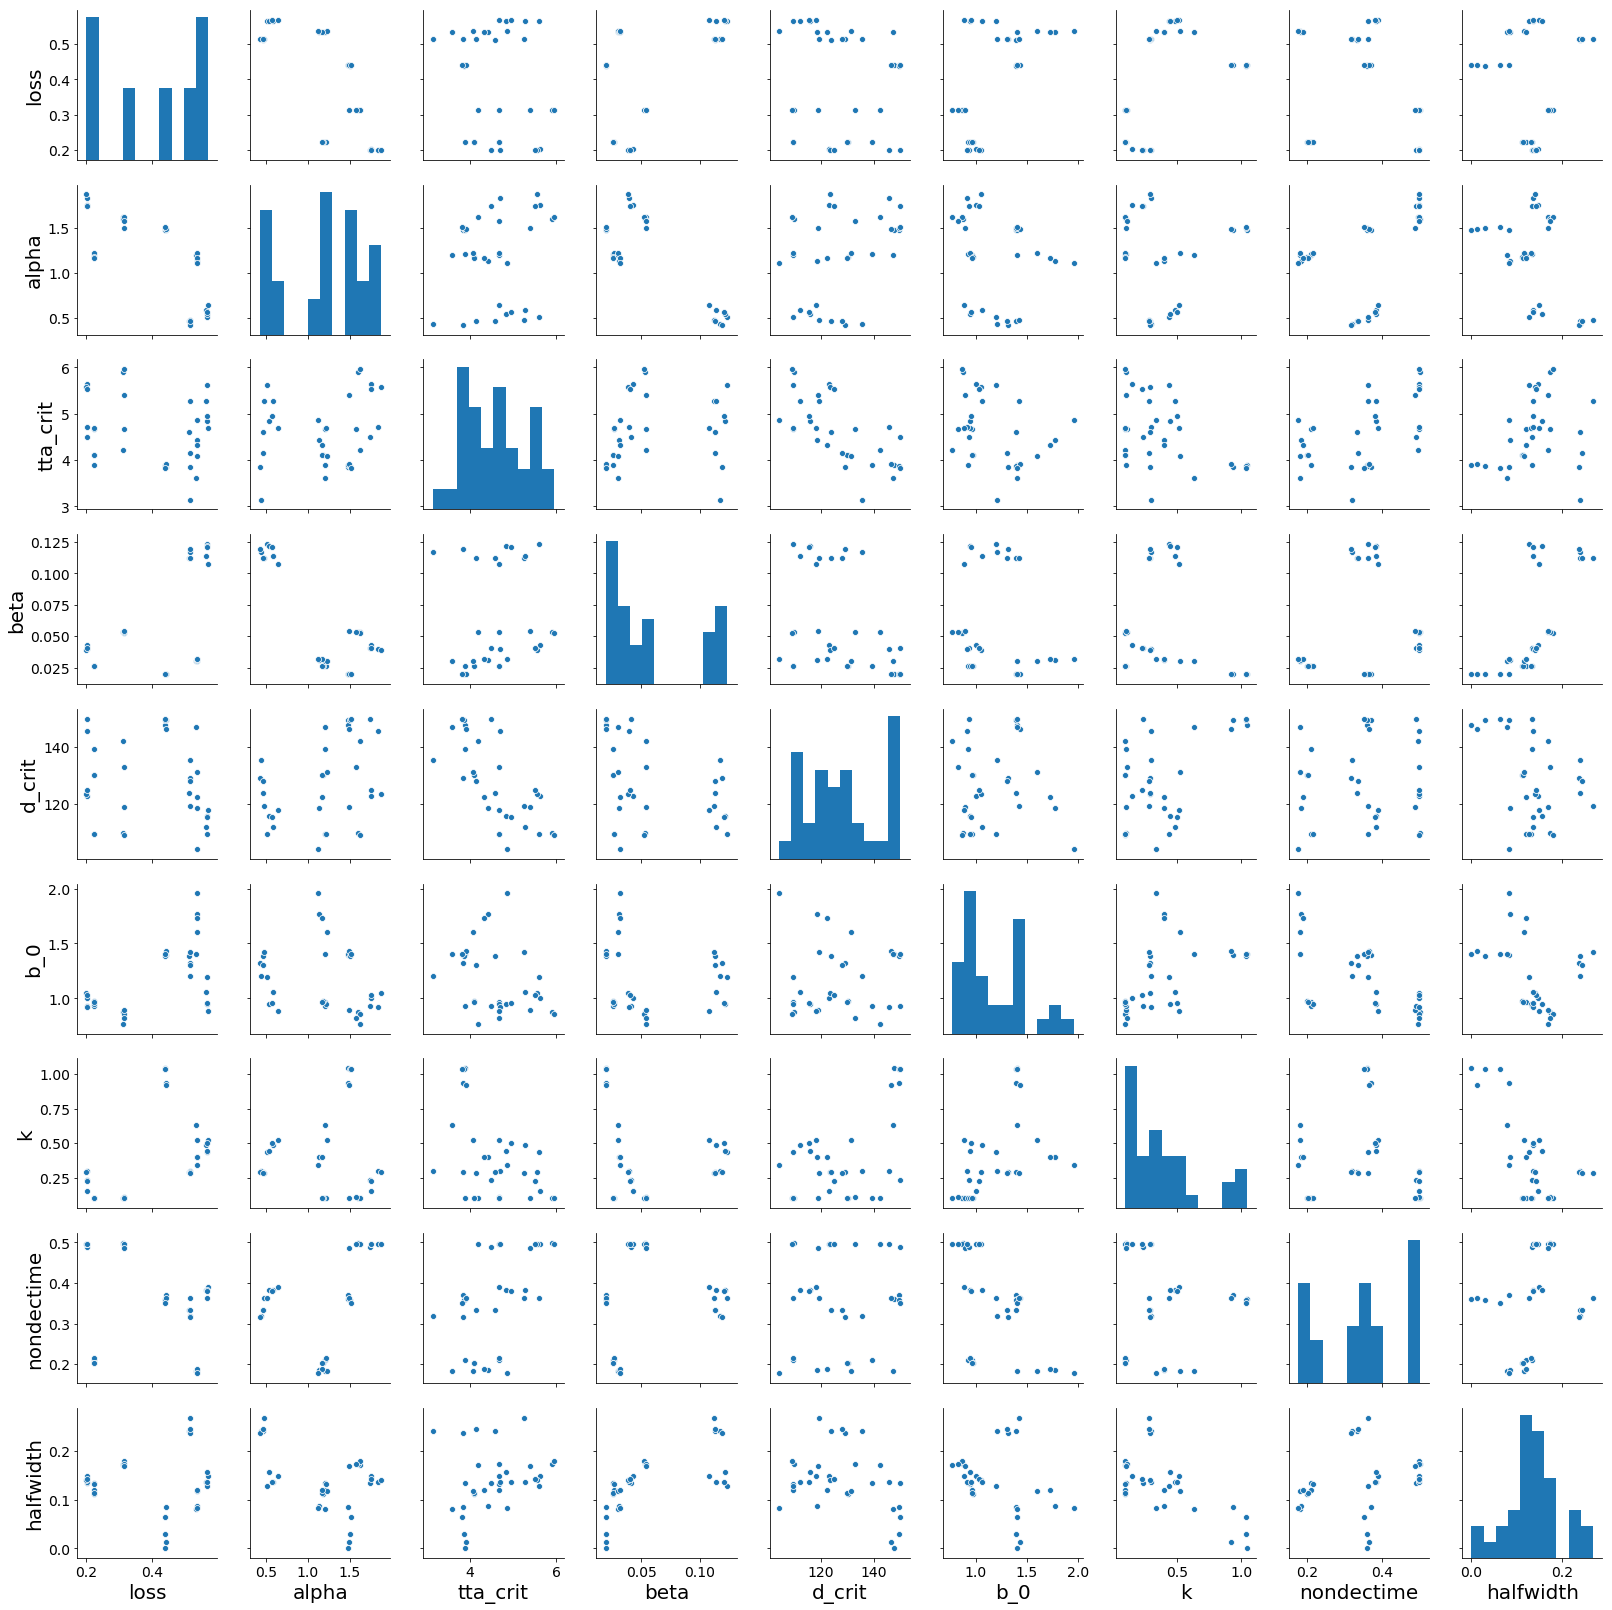

In [3]:
sns.pairplot(parameters, 
             vars=['loss', 'alpha', 'tta_crit', 'beta', 'd_crit', 'b_0', 'k', 'nondectime', 'halfwidth'])

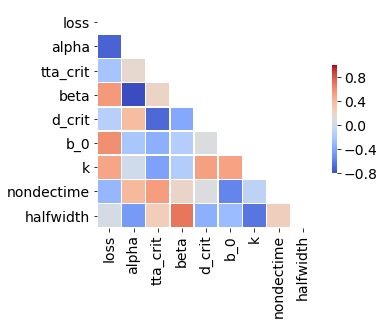

In [6]:
corr = parameters[['loss', 'alpha', 'tta_crit', 'beta', 'd_crit', 'b_0', 'k', 'nondectime', 'halfwidth']].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots()
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cmap='coolwarm', cbar_kws={'shrink': .5})

6.026922644478815
11.834915097951583
7.409152876099876
10.524300719252215
8.360460041257346
18.177224117698454
18.74601229837933


(90, 160)

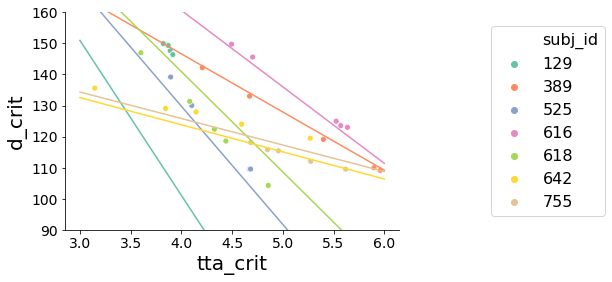

In [21]:
ax = sns.scatterplot(data=parameters, x='tta_crit', y='d_crit', 
                hue='subj_id', palette=sns.color_palette('Set2', parameters.subj_id.nunique()))
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
for i, subj_id in enumerate(parameters.subj_id.unique()):
    data = parameters[parameters.subj_id == subj_id]
    reg_coeffs = scipy.stats.linregress(x=data.tta_crit, y=data.d_crit)
    x = np.linspace(3.0, 6.0, 20)    
#     slope=reg_coeffs.slope
    slope = -1/data.beta.mean()
    intercept = reg_coeffs.intercept
    print(intercept*data.beta.mean())
    y = intercept+x*slope
    ax.plot(x, y, color=sns.color_palette('Set2')[i])
ax.set_ylim((90,160))